<a href="https://colab.research.google.com/github/lukasztracz195/MNIST_ZERO_GAN/blob/main/MNIST_ALL_DIGITS_GAN_AFTER_100_EPOCS_WIHT_CHANGES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Implementacja sieci GAN do nauczenia się jak wygląda liczba 0

##Import bibliotek

###Ustawienie odpowiedniej biblioteki TensoreFlow

In [1]:
# To determine which version you're using:
!pip show tensorflow

# For a specific version:
!pip install tensorflow==1.9

Name: tensorflow
Version: 1.9.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: opensource@google.com
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: tensorboard, numpy, grpcio, absl-py, gast, six, termcolor, setuptools, wheel, astor, protobuf
Required-by: Keras, fancyimpute


###Instalacja odpowiedniej biblioteki Keras

In [2]:
!pip3 install keras==2.0
!pip3 show keras

Name: Keras
Version: 2.0.0
Summary: Deep Learning for Python
Home-page: https://github.com/fchollet/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: /usr/local/lib/python3.6/dist-packages
Requires: tensorflow, six, pyyaml
Required-by: textgenrnn, keras-vis, kapre, fancyimpute


###Instalacja odpowiednich zbiorów danych

In [3]:
%%bash
pip install python-mnist
pip install tensorflow-datasets

In [4]:
import numpy as np
import time

from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.keras import layers

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop

import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

#Implementacja klasy ElapsedTimer

In [5]:
class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time) )

##Sieci GAN są trudne do trenowania
#####Trening GAN polega na znalezieniu równowagi Nasha do gry dla dwóch graczy, która nie jest kooperacyjna. […] Niestety znalezienie równowagi Nasha jest bardzo trudnym problemem. Istnieją algorytmy dla wyspecjalizowanych przypadków, ale nie znamy żadnych możliwych do zastosowania w grze GAN, w której funkcje kosztów są niewypukłe, parametry są ciągłe, a przestrzeń parametrów jest niezwykle wielowymiarowa


###Największe problemy sieci GAN:
#####1. Być może najtrudniejszym problemem jest przypadek, w którym wiele sygnałów wejściowych trafiających do generatora powoduje wygenerowanie tego samego wyjścia.

Nazywa się to „ upadkiem trybu / mode collapse ” i może stanowić jeden z najtrudniejszych problemów podczas uczenia sieci GAN.

"Mode collapse, znany również jako scenariusz problemu, który pojawia się, gdy generator uczy się mapować kilka różnych wejściowych wartości do tego samego punktu wyjściowego."

####2. Nie ma dobrych obiektywnych mierników do oceny, czy GAN działa dobrze podczas treningu. Np. Ocena straty nie jest wystarczająca.

Zamiast tego najlepszym podejściem jest wizualna inspekcja wygenerowanych przykładów i zastosowanie subiektywnej oceny.


###Wskazówki znalezione w sieci dotyczące modelowania sieci GAN:

### 1.Normalizuj wejścia do zakresu [-1, 1] i użyj tg na wyjściu generatora.
### 2.Odwróć etykiety i funkcję utraty podczas szkolenia generatora.
### 3. Przykładowe liczby losowe Gaussa jako dane wejściowe do generatora.
### 4. Użyj mini partii wszystkich prawdziwych lub wszystkich fałszywych do obliczania statystyk norm partii.
### 5. Użyj Leaky ReLU w generatorze i dyskryminatorze.
### 6. Użyj średniej puli i kroku do próbkowania w dół; użyj ConvTranspose2D i stride do upsamplingu.
### 7. Użyj wygładzania etykiet w dyskryminatorze z małym przypadkowym szumem.
### 8. Dodaj losowy szum do etykiet w dyskryminatorze.
### 9. Używaj architektury DCGAN, chyba że masz dobry powód by używać innej.
### 10. Utrata 0,0 w dyskryminatorze jest stanem awarii.
### 11. Jeśli utrata generatora stale się zmniejsza, prawdopodobnie oszukuje dyskryminator obrazami śmieci.
### 12. Użyj etykiet, jeśli je masz.
### 13. Dodaj szum do wejść dyskryminatora i zanikaj go w czasie.
### 14. Użyj 50 procent spadku podczas treningu i generowania.


#Implementacja klasy DCGAN


In [11]:
class DCGAN(object):
    def __init__(self, img_rows=28, img_cols=28, channel=1):

        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel
        self.D = None   # discriminator
        self.G = None   # generator
        self.AM = None  # adversarial model // model przeciwności
        self.DM = None  # discriminator model // model dyskrymiancji

    # (W−F+2P)/S+1
    '''
    W sieciach GAN zaleca się, aby nie używać warstw łączących,
    a zamiast tego używać kroku w warstwach konwolucyjnych
    do wykonywania próbkowania w dół w modelu dyskryminatora
    '''
    '''
    ReLU jest zalecany dla generatora, ale nie dla modelu dyskryminatora.
    Zamiast tego w dyskryminatorze preferowana jest odmiana ReLU,
    która dopuszcza wartości mniejsze od zera, zwana Leaky ReLU.
    '''
    '''
    W praktyce dyskryminator jest zwykle głębszy
    i czasami ma więcej filtrów na warstwę niż generator.
    '''
    def discriminator(self):
        if self.D:
            return self.D
        self.D = Sequential()
        depth = 64
        dropout = 0.4
        # In: 28 x 28 x 1, depth = 1
        # Out: 14 x 14 x 1, depth=64
        input_shape = (self.img_rows, self.img_cols, self.channel)
        self.D.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape,\
            padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*8, 5, strides=1, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        # Out: 1-dim probability
        self.D.add(Flatten())
        self.D.add(Dense(1))
        #Na końcu potrzebujemy wartości[0,1] 0=fake 1=true
        self.D.add(Activation('sigmoid')) 
        self.D.summary()
        return self.D

    def generator(self):
        if self.G:
            return self.G
        self.G = Sequential()
        dropout = 0.4
        depth = 64+64+64+64
        dim = 7
        # In: 100
        # Out: dim x dim x depth
        self.G.add(Dense(dim*dim*depth, input_dim=100))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(LeakyReLU(alpha=0.2))
        self.G.add(Reshape((dim, dim, depth)))
        self.G.add(Dropout(dropout))

        # In: dim x dim x depth
        # Out: 2*dim x 2*dim x depth/2
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(LeakyReLU(alpha=0.2))

        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(LeakyReLU(alpha=0.2))

        self.G.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(LeakyReLU(alpha=0.2))

        # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
        self.G.add(Conv2DTranspose(1, 5, padding='same'))
        self.G.add(Activation('tanh'))
        self.G.summary()
        return self.G

    def discriminator_model(self):
        if self.DM:
            return self.DM
        optimizer = Adam(lr=0.0002, beta_1=0.5)
        self.DM = Sequential()
        self.DM.add(self.discriminator())
        self.DM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.DM

    def adversarial_model(self):
        if self.AM:
            return self.AM
        optimizer = Adam(lr=0.0002, beta_1=0.5)
        self.AM = Sequential()
        self.AM.add(self.generator())
        self.AM.add(self.discriminator())
        self.AM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.AM



#Implementacja klasy MNIST_DCGAN

In [12]:
class MNIST_DCGAN(object):
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channel = 1

        self.x_train = input_data.read_data_sets("mnist",\
        	one_hot=True).train.images
        self.x_train = self.x_train.reshape(-1, self.img_rows,\
        	self.img_cols, 1).astype(np.float32)

        self.DCGAN = DCGAN()
        self.discriminator =  self.DCGAN.discriminator_model()
        self.adversarial = self.DCGAN.adversarial_model()
        self.generator = self.DCGAN.generator()

    def train(self, train_steps=2000, batch_size=256, save_interval=0):
        noise_input = None
        if save_interval>0:
            noise_input = np.random.normal(0.0, 0.2, size=[16, 100])
        for i in range(train_steps):
            images_train = self.x_train[np.random.randint(0,
                self.x_train.shape[0], size=batch_size), :, :, :]
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            images_fake = self.generator.predict(noise)
            x = np.concatenate((images_train, images_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            d_loss = self.discriminator.train_on_batch(x, y)

            y = np.ones([batch_size, 1])
            noise = np.random.normal(0.0, 0.2, size=[batch_size, 100])
            a_loss = self.adversarial.train_on_batch(noise, y)
            log_mesg = "%d: [Discriminator loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [Generator loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            print(log_mesg)
            if save_interval>0:
                if (i+1)%save_interval==0:
                    self.plot_images(save2file=True, samples=noise_input.shape[0],\
                        noise=noise_input, step=(i+1))

    def plot_images(self, save2file=False, fake=True, samples=16, noise=None, step=0):
        filename = 'mnist.png'
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                filename = "mnist_%d.png" % step
            images = self.generator.predict(noise)
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i, :, :, :]

        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.img_rows, self.img_cols])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()

#Uruchomienie działania GANA

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_12 (Dropout)         (None

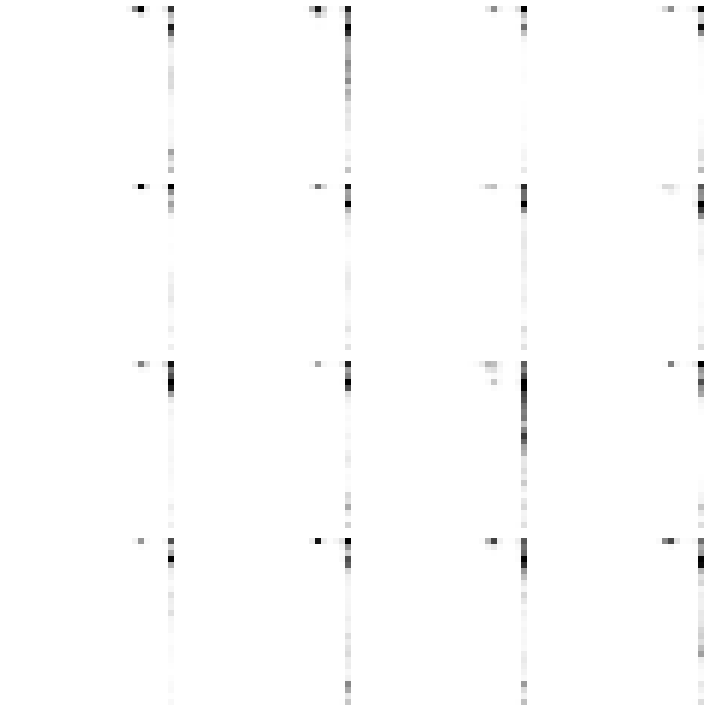

In [13]:

mnist_dcgan = MNIST_DCGAN()
timer = ElapsedTimer()
mnist_dcgan.train(train_steps=100, batch_size=256, save_interval=500)
timer.elapsed_time()
mnist_dcgan.plot_images(fake=True)
mnist_dcgan.plot_images(fake=False, save2file=True)